# Libraries

In [155]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
from IPython.display import display
import holidays
import seaborn as sns
from math import sqrt
import pickle

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

# Utils

In [149]:
def read_file(path,dropna=True):
    p = path.replace('\\','/')
    df = pd.read_excel(p)
    if dropna:
        df.dropna(inplace=True)
    display(df.head())
    display(df.info())
    display('The shape of the DataFrame is:',df.shape)
    return df

def dropper(df,col_name):
    df_temp = df.drop(col_name,axis=1)
    return df_temp

def journey(df):
    df_temp = df.copy(deep=True)
    india_holidays = holidays.India()
    df_temp[['Date_of_Journey']]=pd.to_datetime(df_temp['Date_of_Journey'])
    df_temp['Holiday']=(df_temp['Date_of_Journey'].isin(india_holidays)).astype(int)
    
    if len(list(df_temp['Holiday'].unique()))<2:
        df_temp = dropper(df_temp,'Holiday')
        print('There are no Holidays!!!')
        
    df_temp['Journey Date']=df_temp['Date_of_Journey'].dt.day
    df_temp['Journey Month']=df_temp['Date_of_Journey'].dt.month
#     df_temp['Journey Year']=df_temp['Date_of_Journey'].dt.year
    df_temp['Journey Day'] = df_temp['Date_of_Journey'].dt.dayofweek
    df_temp['Journey Weekend'] = np.where(((df_temp['Date_of_Journey']).dt.dayofweek) > 5,1,0)
    df_temp['Journey Week']=df_temp['Date_of_Journey'].dt.week
    
    display(df_temp.head())
    
    return df_temp

def durations(df):
    df_temp =df.copy(deep=True)
    duration = list(df_temp.Duration)
    for i in range(len(duration)):
        if len(duration[i].split())!=2:
            if 'h' in duration[i]:
                duration[i] = duration[i].strip()+' 0m'
            else:
                duration[i] = '0h ' + duration[i].strip()

    duration_hour =[]
    duration_min = []

    for i in range(len(duration)):
        duration_hour.append(duration[i].split(sep='h')[0])
        duration_min.append(duration[i].split(sep='m')[0].split()[-1])
        
    df_temp = dropper(df_temp,['Duration'])
   
    df_temp['Duration_hour']=duration_hour
    df_temp['Duration_min']=duration_min
    
    df_temp['Duration_min_scaled'] =df_temp['Duration_min'].astype(float)/60 #converting it into the hours
    df_temp['Duration'] = df_temp['Duration_hour'].astype(float)+df_temp['Duration_min_scaled']
    
    df_temp = dropper(df_temp,['Duration_min_scaled','Duration_hour','Duration_min'])
    
    display(df_temp.head())
    
    return df_temp

def stops(df):
    df_temp = df.copy(deep=True)
    stops = {'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4}
    df_temp['Total_Stops']=df_temp['Total_Stops'].map(stops)
    
    display(df_temp.head())
    
    return df_temp

def timing(x):
    if (x > 7) and (x <= 12):
        return 'Morning'
    elif (x > 12) and (x <= 17 ):
        return 'Afternoon'
    elif (x > 17) and (x <= 20):
        return'Evening'
    elif (x > 20) or (x<=7):
        return 'Night'

def times(df):
    df_temp = df.copy(deep=True)
    
    df_temp['Dep_Time']=pd.to_datetime(df_temp['Dep_Time'],format='%H:%M')
    df_temp['Arrival_Time1']=df_temp['Arrival_Time'].apply(lambda x: x.split()[0])
    df_temp['Arrival_Time1']=pd.to_datetime(df_temp['Arrival_Time1'],format='%H:%M')
    
    df_temp['Dep_Duration']=df_temp['Dep_Time'].dt.hour.apply(timing)+'_dep'
    df_temp['Arrival_Duration']=df_temp['Arrival_Time1'].dt.hour.apply(timing) +'_arr'
    
    df_temp=dropper(df_temp,['Arrival_Time1','Dep_Time','Arrival_Time'])
    display(df_temp.head())
    
    return df_temp

def encoder(df,name):
    source = df[[name]]
    df_temp = pd.get_dummies(source,drop_first=True)
    return df_temp

def metric(actual,predicted):
    e_mse = mse(actual,predicted)
    e_mae = mae(actual,predicted)
    e_r2 = r2(actual,predicted)
    e_agm = ((sqrt(e_mse)+e_mae)/2)*(1-e_r2)
    
    return e_mse,sqrt(e_mse),e_mae,e_r2,e_agm

# Main

In [75]:
path = os.getcwd()+'\\Dataset\\Data_Train.xlsx'
train_df = read_file(path,True)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


None

'The shape of the DataFrame is:'

(10682, 11)

## Date of Journey Column

In [76]:
train_df = journey(train_df)

There are no Holidays!!!


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6,1,12
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,1,5,0,1
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,6,9,4,0,36
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,5,12,3,0,49
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,3,1,3,0,1


In [77]:
train_df = dropper(train_df,['Date_of_Journey','Route'])

In [78]:
train_df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6,1,12
1,Air India,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662,5,1,5,0,1
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882,6,9,4,0,36
3,IndiGo,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218,5,12,3,0,49
4,IndiGo,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302,3,1,3,0,1


## Duration Column

In [79]:
train_df = durations(train_df)

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week,Duration
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,No info,3897,24,3,6,1,12,2.833333
1,Air India,Kolkata,Banglore,05:50,13:15,2 stops,No info,7662,5,1,5,0,1,7.416667
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,No info,13882,6,9,4,0,36,19.000000
3,IndiGo,Kolkata,Banglore,18:05,23:30,1 stop,No info,6218,5,12,3,0,49,5.416667
4,IndiGo,Banglore,New Delhi,16:50,21:35,1 stop,No info,13302,3,1,3,0,1,4.750000


## Additional Info & Total Stops columns

In [80]:
train_df['Additional_Info'].value_counts()/train_df.shape[0]

No info                         0.781127
In-flight meal not included     0.185546
No check-in baggage included    0.029957
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
2 Long layover                  0.000094
1 Short layover                 0.000094
Red-eye flight                  0.000094
Name: Additional_Info, dtype: float64

In [81]:
train_df = dropper(train_df,['Additional_Info'])

In [82]:
train_df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [83]:
train_df = stops(train_df)

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week,Duration
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,0,3897,24,3,6,1,12,2.833333
1,Air India,Kolkata,Banglore,05:50,13:15,2,7662,5,1,5,0,1,7.416667
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2,13882,6,9,4,0,36,19.000000
3,IndiGo,Kolkata,Banglore,18:05,23:30,1,6218,5,12,3,0,49,5.416667
4,IndiGo,Banglore,New Delhi,16:50,21:35,1,13302,3,1,3,0,1,4.750000


## Departure and Arrival time

In [84]:
train_df = times(train_df)

,Airline,Source,Destination,Total_Stops,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week,Duration,Dep_Duration,Arrival_Duration
0,IndiGo,Banglore,New Delhi,0,3897,24,3,6,1,12,2.833333,Night_dep,Night_arr
1,Air India,Kolkata,Banglore,2,7662,5,1,5,0,1,7.416667,Night_dep,Afternoon_arr
2,Jet Airways,Delhi,Cochin,2,13882,6,9,4,0,36,19.000000,Morning_dep,Night_arr
3,IndiGo,Kolkata,Banglore,1,6218,5,12,3,0,49,5.416667,Evening_dep,Night_arr
4,IndiGo,Banglore,New Delhi,1,13302,3,1,3,0,1,4.750000,Afternoon_dep,Night_arr


## Categorical Variables

In [120]:
train_airline = encoder(train_df,'Airline')
train_source = encoder(train_df,'Source')
train_destination = encoder(train_df,'Destination')
train_dduration = encoder(train_df,'Dep_Duration')
train_aduration = encoder(train_df,'Arrival_Duration')

## Combining

In [121]:
train = pd.concat([train_df,train_airline,train_source,
                   train_destination,train_dduration,train_aduration],axis=1)

train = dropper(train,['Airline','Source','Destination','Dep_Duration','Arrival_Duration'])

In [122]:
train.head()

,Total_Stops,Price,Journey Date,Journey Month,Journey Day,Journey Weekend,Journey Week,Duration,Airline_Air India,Airline_GoAir,...,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Dep_Duration_Evening_dep,Dep_Duration_Morning_dep,Dep_Duration_Night_dep,Arrival_Duration_Evening_arr,Arrival_Duration_Morning_arr,Arrival_Duration_Night_arr
0,0,3897,24,3,6,1,12,2.833333,0,0,...,0,0,0,1,0,0,1,0,0,1
1,2,7662,5,1,5,0,1,7.416667,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2,13882,6,9,4,0,36,19.000000,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,6218,5,12,3,0,49,5.416667,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,13302,3,1,3,0,1,4.750000,0,0,...,0,0,0,1,0,0,0,0,0,1


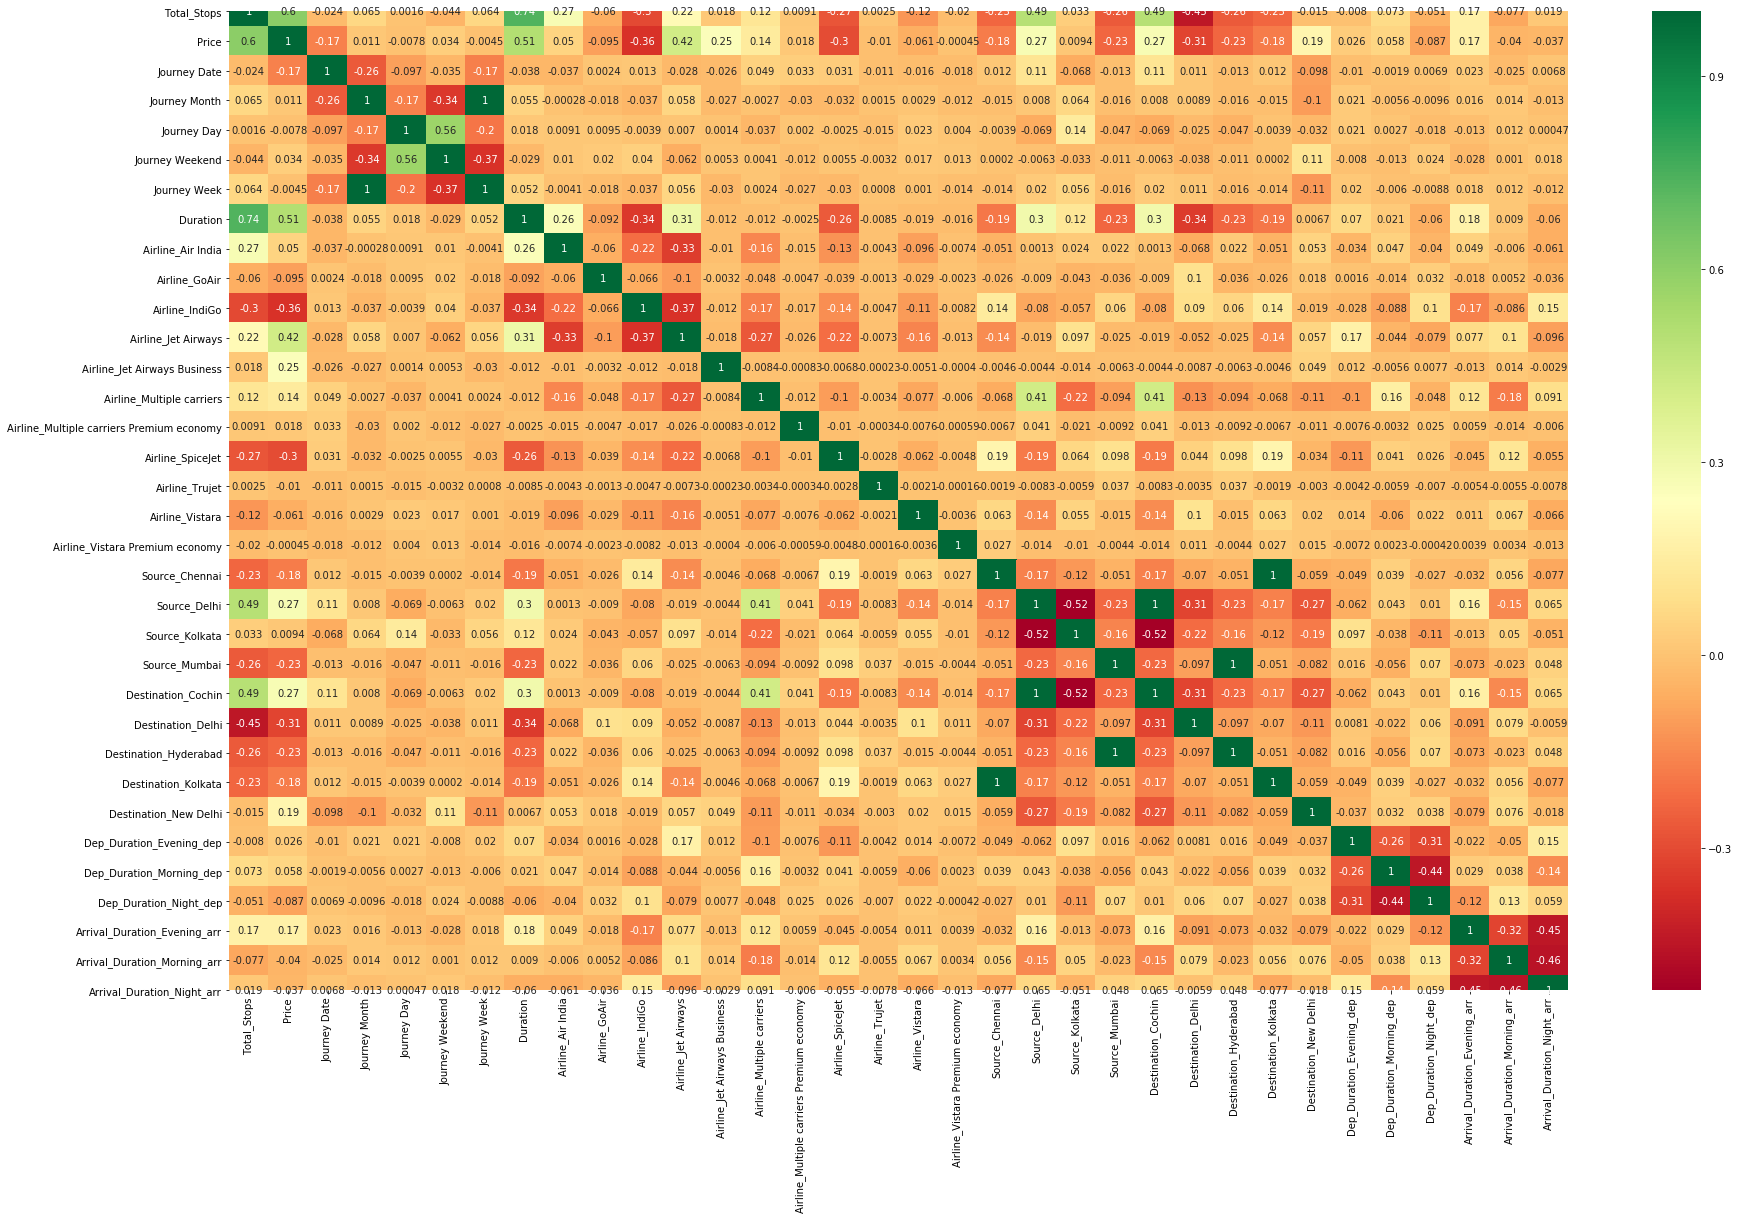

In [123]:
plt.figure(figsize = (30,18))
sns.heatmap(train.corr(), annot = True, cmap = "RdYlGn")

plt.show()

## Feature Selection

In [128]:
x = train[['Total_Stops', 'Journey Date', 'Journey Month', 'Journey Day',
       'Journey Weekend', 'Journey Week', 'Duration', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Dep_Duration_Evening_dep', 'Dep_Duration_Morning_dep',
       'Dep_Duration_Night_dep', 'Arrival_Duration_Evening_arr',
       'Arrival_Duration_Morning_arr', 'Arrival_Duration_Night_arr']]

y = train[['Price']]

print(f'The shape of x is {x.shape} and y is {y.shape}')

The shape of x is (10682, 33) and y is (10682, 1)


In [129]:
selector = ExtraTreesRegressor()
selector.fit(x,y)

/Users/saad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor()

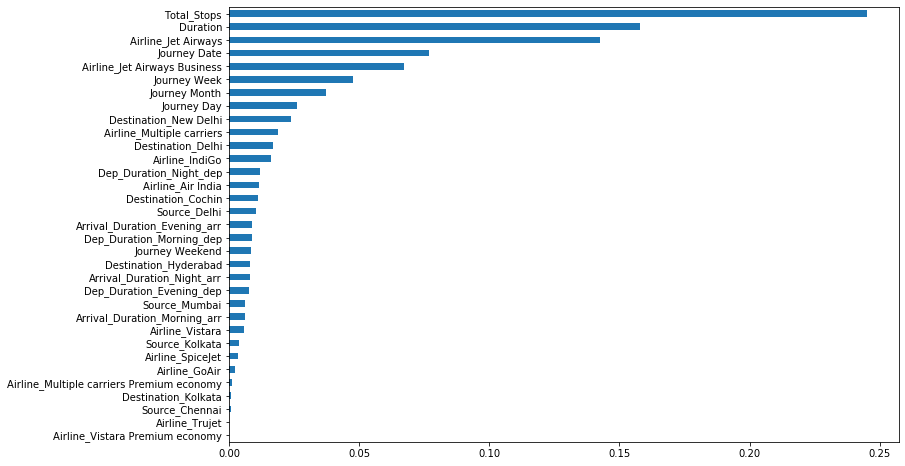

In [130]:
#plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selector.feature_importances_, index=x.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

## Model Creation and Hyperparamter Tunning

In [131]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

The shape of x_train is (8545, 33) and x_test is (2137, 33)
The shape of y_train is (8545, 1) and y_test is (2137, 1)


In [135]:
regressor = RandomForestRegressor()

In [136]:
#Hyperparameter Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [137]:
tuner = RandomizedSearchCV(estimator = regressor, 
                               param_distributions = random_grid,scoring='neg_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [138]:
tuner.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.7s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.2s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   3.9s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.0s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.2s
[CV] n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15, total=   2.5s
[CV] n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15, total=   2.5s
[CV] n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15, total=   2.5s
[CV] n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15, total=   2.5s
[CV] n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=100, min_samples_leaf=5, max_features=auto, max_depth=15, total=   2.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15, total=   4.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15, total=   4.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15, total=   4.6s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15, total=   4.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=15, total=   4.5s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20, total=   7.0s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20, total=   7.0s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20, total=   7.1s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20, total=   7.0s
[CV] n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=20, total=   7.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   6.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   6.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   6.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   6.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   6.1s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   2.2s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   2.2s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   2.2s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   2.2s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   2.2s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.1s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.1s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20, total=   8.2s
[CV] n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20, total=   8.1s
[CV] n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20, total=   8.2s
[CV] n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20, total=   8.1s
[CV] n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20 


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=700, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=20, total=   8.2s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished
/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [139]:
tuner.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [151]:
preds = tuner.predict(x_test)

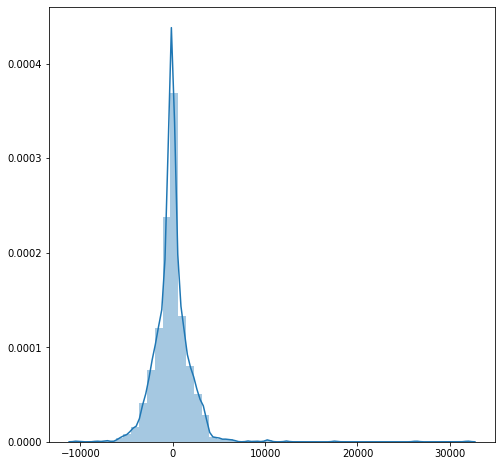

In [152]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-preds.reshape(-1,1))
plt.show()

In [153]:
e_mse,e_rmse,e_mae,e_r2,e_agg = metric(y_test,preds)

print('MSE:',e_mse)
print('RMSE:',e_rmse)
print('MAE:',e_mae)
print('R2:',e_r2)
print('AGM:',e_agg)

MSE: 4093065.220891382
RMSE: 2023.1325267741067
MAE: 1252.7785273774039
R2: 0.8101727794716491
AGM: 310.9285450538406


## Saving the model

In [162]:
file = open('flight_fare.pkl', 'wb')

# dump information to that file
pickle.dump(tuner, file)

file.close()